In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import pickle
from imblearn.under_sampling import RandomUnderSampler

importing spam_Emails_data.csv

In [2]:
df0=pd.read_csv("./data/emails.csv")
df0.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
df0['text'] = df0['text'].str.replace(r'^Subject: ', '', regex=True)

In [4]:
df0.head(2)

,text,spam
0,naturally irresistible your corporate identity...,1
1,the stock trading gunslinger fanny is merrill...,1


In [5]:
df1=pd.read_csv("./data/spam.csv")
df1

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
df1.rename(columns={"Category":"spam","Message":"text"},inplace=True)

In [7]:
df1['spam']=df1['spam'].map({"spam":1,"ham":0})

In [8]:
df1.head(2)

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...


In [9]:
df2=pd.read_csv("./data/spam1.csv")
df2.head()

,text,spam
0,Does Hanuman Chalisa do miracles? Has anyone w...,1
1,"[$32,500 in Prizes] Wager, Refer and win big t...",1
2,🚨 Educative is half off today,1
3,[ClubRiches] Triple Your Deposit with FreeBitc...,1
4,Your Weekly Moment with Aura: Becoming your ow...,1


In [10]:
df2.shape

(150, 2)

In [11]:
df2['spam'].unique()

array([1], dtype=int64)

In [12]:
df2['spam'].value_counts()

spam
1    150
Name: count, dtype: int64

In [13]:
df=pd.concat([df0,df1,df2],ignore_index=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11450 entries, 0 to 11449
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11450 non-null  object
 1   spam    11450 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 179.0+ KB


In [15]:
df['spam'].value_counts()

spam
0    9185
1    2265
Name: count, dtype: int64

In [16]:
df.shape

(11450, 2)

In [17]:
df.isna().sum()

text    0
spam    0
dtype: int64

In [18]:
df.dropna(inplace=True)

In [19]:
df.duplicated().sum()

461

In [20]:
df.drop_duplicates(inplace=True)

In [21]:
df.sample(3)

,text,spam
9649,FREE>Ringtone! Reply REAL or POLY eg REAL1 1. ...,1
6399,Ho ho - big belly laugh! See ya tomo,0
8401,Super msg da:)nalla timing.,0


In [22]:
df['spam'].unique()

array([1, 0], dtype=int64)

In [23]:
df['spam'].value_counts()

spam
0    8843
1    2146
Name: count, dtype: int64

In [24]:
ham_df=df[df['spam']==0]
ham_df

,text,spam
1368,"hello guys , i ' m "" bugging you "" for your c...",0
1369,sacramento weather station fyi - - - - - - -...,0
1370,from the enron india newsdesk - jan 18 th news...,0
1371,re : powerisk 2001 - your invitation angelika...,0
1372,re : resco database and customer capture stev...,0
...,...,...
11293,Huh y lei...,0
11296,Will ü b going to esplanade fr home?,0
11297,"Pity, * was in mood for that. So...any other s...",0
11298,The guy did some bitching but I acted like i'd...,0


In [25]:
spam_df=df[df['spam']==1]
spam_df

,text,spam
0,naturally irresistible your corporate identity...,1
1,the stock trading gunslinger fanny is merrill...,1
2,unbelievable new homes made easy im wanting t...,1
3,4 color printing special request additional i...,1
4,"do not have money , get software cds from here...",1
...,...,...
11442,⏰ New Podcast Alert! ⏰,1
11443,🚀 Grab Your Spot Now!,1
11446,Your Weekly Moment with Aura: Heaven & Hell,1
11448,Here's how to get job-ready this June,1


In [26]:
print('Spam percentage = ', (len(spam_df)/len(df))*100, '%')

Spam percentage =  19.52861952861953 %


In [27]:
print('Ham percentage = ', (len(ham_df)/len(df))*100, '%')

Ham percentage =  80.47138047138047 %


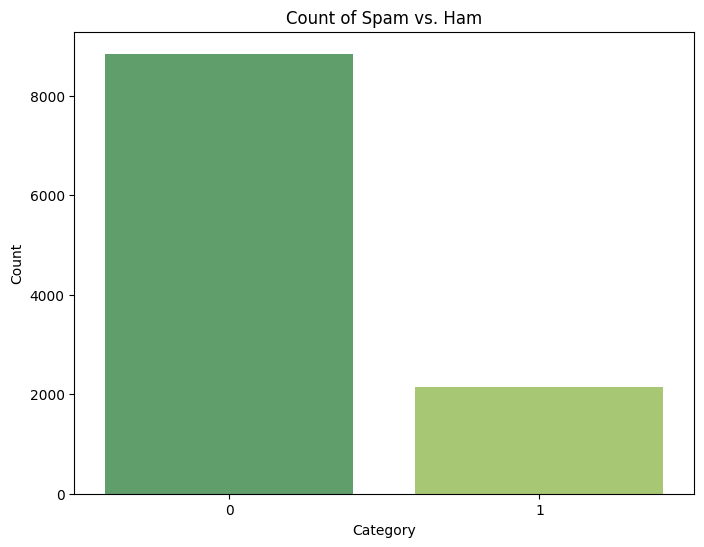

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(x='spam', hue='spam', data=df, palette='summer',legend=False)
plt.title('Count of Spam vs. Ham')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

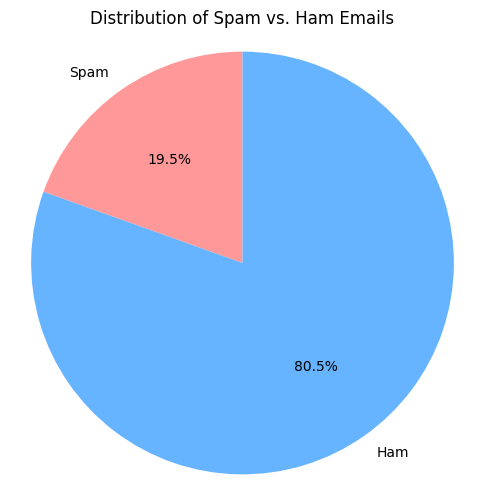

In [29]:
spam_count = df['spam'].sum()
ham_count = len(df) - spam_count  # Total rows minus spam rows
# Plot pie chart
labels = 'Spam', 'Ham'
sizes = [spam_count, ham_count]
colors = ['#ff9999', '#66b3ff']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Spam vs. Ham Emails')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [30]:
# pip install nltk

In [31]:
import nltk
# nltk.download()

In [32]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
import string
from nltk.corpus import stopwords

stopwords.words('english')
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
# !pip install tqdm


In [35]:
from tqdm import tqdm
tqdm.pandas()

In [36]:
# def message_cleaning(message):
#     Test_punc_removed = [char for char in message if char not in string.punctuation]
#     Test_punc_removed_join = ''.join(Test_punc_removed)
#     Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
#     return Test_punc_removed_join_clean

In [37]:
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Function to convert emojis to text
def convert_emojis_to_text(text):
    return emoji.demojize(text)

# Function to clean text
def clean_text(text):
    # Convert emojis to text
    text = convert_emojis_to_text(text)
    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    text = ' '.join(word for word in words if word not in stop_words)
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

# Apply the cleaning function to the email text
df['cleaned_text'] = df['text'].progress_apply(clean_text)

100%|██████████| 10989/10989 [00:14<00:00, 782.52it/s] 


In [38]:
# Feature engineering: Length of the email
df['email_length'] = df['text'].apply(len)

In [39]:
# df10=df[['spam',"cleaned_text"]]

In [40]:
# df10.to_csv("cleaned_dataset.csv",index=False)

In [41]:
print(spam_df['text'][0])

naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  marketing br

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
spamham_cv = vectorizer.fit_transform(df['cleaned_text'])


In [43]:
print(vectorizer.get_feature_names_out())

['aa' 'aaa' 'aaaenerfax' ... 'zzzz' 'èn' '〨ud']


In [44]:
print(spamham_cv.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [45]:
spamham_cv.shape

(10989, 34069)

In [46]:
label = df['spam'].values
label

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [47]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(spamham_cv, label)


MultinomialNB()

In [48]:
testing_sample=['Free Money!!!',' Hi Jane, Please let me know if you want to modify our project.']
testing_sample_vectorizer = vectorizer.transform(testing_sample)

In [49]:
print(testing_sample_vectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [50]:
test_predict = NB_classifier.predict(testing_sample_vectorizer)
test_predict

array([1, 0], dtype=int64)

In [51]:
sampletwo = ['Free Money !!!','I am hungry. Let us go to eat.']
sampletwo_vectorizer= vectorizer.transform(sampletwo)

In [52]:
test_predicttwo = NB_classifier.predict(sampletwo_vectorizer)
test_predicttwo

array([1, 0], dtype=int64)

In [53]:
samplethree = ['Hello ! I am coming home.','WOW!! Shop on full discount!!']
samplethree_vectorizer = vectorizer.transform(samplethree)

In [54]:
test_predictthree = NB_classifier.predict(samplethree_vectorizer)
test_predictthree

array([0, 1], dtype=int64)

In [55]:
new_emails = [
    "Congratulations! You've won a free ticket to Bahamas!",
    "Hey, can we reschedule our meeting to next week?",
    "Limited time offer, buy now and save big!"
]

In [56]:
new_emails_counts = vectorizer.transform(new_emails)

In [57]:
proba = NB_classifier.predict_proba(new_emails_counts)

In [58]:
for email, p in zip(new_emails, proba):
    print(f"Email: {email}")
    print(f"Probability of being Ham: {p[0]:.4f}")
    print(f"Probability of being Spam: {p[1]:.4f}\n")

Email: Congratulations! You've won a free ticket to Bahamas!
Probability of being Ham: 0.0574
Probability of being Spam: 0.9426

Email: Hey, can we reschedule our meeting to next week?
Probability of being Ham: 0.9989
Probability of being Spam: 0.0011

Email: Limited time offer, buy now and save big!
Probability of being Ham: 0.0060
Probability of being Spam: 0.9940



In [59]:
emails = [
    "Free money now!!!", 
    "Hi John, how are you?", 
    "Earn cash fast!", 
    "Meeting tomorrow at 10am", 
    "You won a prize!"
]
labels = ["spam", "ham", "spam", "ham", "spam"]

# Convert text data to numeric form using CountVectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(emails)

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_counts, labels)

MultinomialNB()

In [78]:
log_prob_spam = nb_classifier.feature_log_prob_[0]  # log P(word|spam)
log_prob_ham = nb_classifier.feature_log_prob_[1]   # log P(word|ham)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to show the words and their log probabilities for spam and ham
df_features = pd.DataFrame({
    'Word': feature_names,
    'Log Prob Spam': log_prob_spam,
    'Log Prob Ham': log_prob_ham
})

# Calculate the difference in log probabilities between spam and ham
df_features['Log Prob Diff (Spam - Ham)'] = df_features['Log Prob Spam'] - df_features['Log Prob Ham']

# Sort by the difference to see which words are more indicative of spam
df_features = df_features.sort_values(by='Log Prob Diff (Spam - Ham)', ascending=False)

# Display the top words indicative of spam
print(df_features.head())

        Word  Log Prob Spam  Log Prob Ham  Log Prob Diff (Spam - Ham)
0       10am      -2.564949     -3.258097                    0.693147
7         hi      -2.564949     -3.258097                    0.693147
14  tomorrow      -2.564949     -3.258097                    0.693147
10   meeting      -2.564949     -3.258097                    0.693147
9       john      -2.564949     -3.258097                    0.693147


In [85]:
new_email = ["Claim your free prize now!!!"]

# Transform the new email to the same format as training data
new_email_counts = vectorizer.transform(new_email)

# Predict probabilities
proba = nb_classifier.predict_proba(new_email_counts)

# Show the prediction
print(f"Probability of Ham: {proba[0][0]:.4f}")
print(f"Probability of Spam: {proba[0][1]:.4f}")

# Get the words in the new email
new_email_words = vectorizer.inverse_transform(new_email_counts)[0]

# Create a DataFrame to show the contribution of each word in the new email
contribution_df = df_features[df_features['Word'].isin(new_email_words)]

print("\nContribution of words in the email:")
print(contribution_df['Word'])

Probability of Ham: 0.0769
Probability of Spam: 0.9231

Contribution of words in the email:
6      free
12      now
13    prize
Name: Word, dtype: object


In [60]:
X=spamham_cv
y= label

In [61]:
X.shape

(10989, 34069)

In [62]:
y.shape

(10989,)

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train ,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [64]:
from sklearn.naive_bayes import MultinomialNB
# Hyperparameter tuning for Naive Bayes using GridSearchCV
parameters = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
NB_classifier = MultinomialNB()
clf = GridSearchCV(NB_classifier, parameters, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='accuracy')

In [65]:
# Best parameter found by GridSearchCV
best_alpha = clf.best_params_['alpha']
print(f'Best alpha parameter: {best_alpha}')

Best alpha parameter: 0.001


In [66]:
# Train the model with best alpha
NB_classifier = MultinomialNB(alpha=best_alpha)
NB_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.001)

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

In [68]:
# Evaluate the model and adjust threshold
y_proba_train = NB_classifier.predict_proba(X_train)[:, 1]  # Probabilities of class 1 (spam)
y_predict_train_adjusted = (y_proba_train >0.9).astype(int)  # Adjust threshold here (e.g., 0.3)

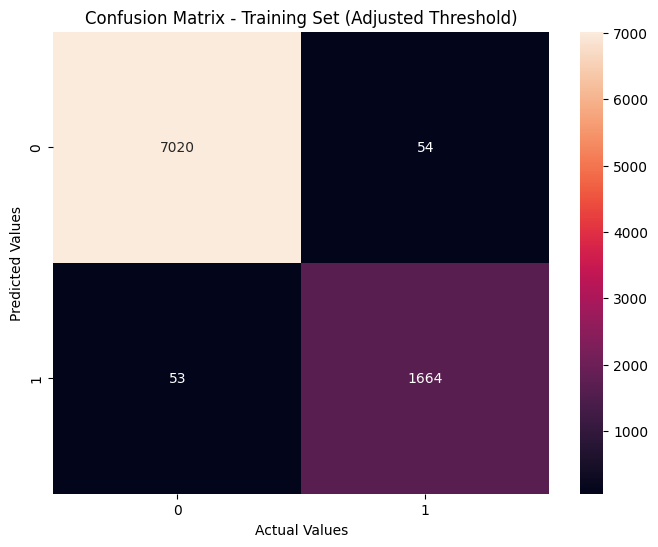

In [69]:
# Evaluate adjusted predictions
cm_train_adjusted = confusion_matrix(y_train, y_predict_train_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_adjusted, annot=True, fmt='d')
plt.title('Confusion Matrix - Training Set (Adjusted Threshold)')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [70]:
print("Classification Report - Training Set (Adjusted Threshold)")
print(classification_report(y_train, y_predict_train_adjusted))


Classification Report - Training Set (Adjusted Threshold)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7074
           1       0.97      0.97      0.97      1717

    accuracy                           0.99      8791
   macro avg       0.98      0.98      0.98      8791
weighted avg       0.99      0.99      0.99      8791



In [71]:
# Plot confusion matrix for test set
y_proba_test = NB_classifier.predict_proba(X_test)[:, 1]  # Probabilities of class 1 (spam)
y_predict_test_adjusted = (y_proba_test > 0.92).astype(int)  # Adjust threshold here (e.g., 0.3)


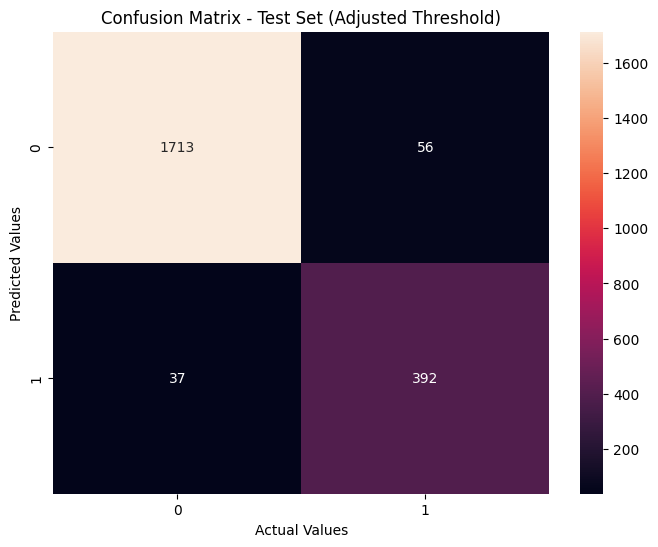

In [72]:
cm_test = confusion_matrix(y_test, y_predict_test_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d')
plt.title('Confusion Matrix - Test Set (Adjusted Threshold)')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [73]:
print("Classification Report - Test Set (Adjusted Threshold)")
print(classification_report(y_test, y_predict_test_adjusted))


Classification Report - Test Set (Adjusted Threshold)
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1769
           1       0.88      0.91      0.89       429

    accuracy                           0.96      2198
   macro avg       0.93      0.94      0.93      2198
weighted avg       0.96      0.96      0.96      2198



In [74]:
import pickle

In [75]:
# Save the- model and vectorizer
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(NB_classifier, model_file)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("Model and vectorizer saved!")

Model and vectorizer saved!


In [76]:

# # Separate into spam and ham datasets
# df_spam = df[df['spam'] == 1]
# df_ham = df[df['spam'] == 0]

# # Vectorize the text using CountVectorizer separately for spam and ham
# vectorizer_spam = CountVectorizer()
# X_spam = vectorizer_spam.fit_transform(df_spam['cleaned_text'])

# vectorizer_ham = CountVectorizer()
# X_ham = vectorizer_ham.fit_transform(df_ham['cleaned_text'])

# # Sum word frequencies for spam and ham
# spam_word_counts = np.asarray(X_spam.sum(axis=0)).ravel()
# ham_word_counts = np.asarray(X_ham.sum(axis=0)).ravel()

# # Get feature names (words)
# spam_features = vectorizer_spam.get_feature_names_out()
# ham_features = vectorizer_ham.get_feature_names_out()

# # Create DataFrame for top words
# top_n = 20
# df_top_spam_words = pd.DataFrame({'Word': spam_features, 'Count': spam_word_counts})
# df_top_ham_words = pd.DataFrame({'Word': ham_features, 'Count': ham_word_counts})

# # Sort by count to get top words
# df_top_spam_words = df_top_spam_words.sort_values(by='Count', ascending=False).head(top_n)
# df_top_ham_words = df_top_ham_words.sort_values(by='Count', ascending=False).head(top_n)

# # Plot top spam words
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Word', y='Count', data=df_top_spam_words, palette='viridis')
# plt.title(f'Top {top_n} Most Used Words in Spam Emails')
# plt.xlabel('Words')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Plot top ham words
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Word', y='Count', data=df_top_ham_words, palette='viridis')
# plt.title(f'Top {top_n} Most Used Words in Ham Emails')
# plt.xlabel('Words')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [77]:
# Example function to check spam and get probabilities
def check_spam_with_prob(email_content):
    email_vectorized = vectorizer.transform([email_content])
    prediction = NB_classifier.predict(email_vectorized)
    probabilities = NB_classifier.predict_proba(email_vectorized)
    spam_prob = probabilities[0][1]
    ham_prob = probabilities[0][0]
    is_spam = bool(prediction[0])
    return is_spam, spam_prob, ham_prob

# Example usage
email_content = "Free money offer inside!"
is_spam, spam_prob, ham_prob = check_spam_with_prob(email_content)

print(f"Is spam: {is_spam}")
print(f"Probability of spam: {spam_prob}")
print(f"Probability of ham: {ham_prob}")

ValueError: X has 17 features, but MultinomialNB is expecting 34069 features as input.

In [ ]:

# # Apply RandomUnderSampler to handle class imbalance
# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(df['cleaned_text'].values.reshape(-1, 1), df['spam'])

# # Vectorize text data
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(X_resampled.ravel())

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# # Train the Naive Bayes classifier
# NB_classifier = MultinomialNB()
# parameters = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
# clf = GridSearchCV(NB_classifier, parameters, cv=5, scoring='accuracy')
# clf.fit(X_train, y_train)

# # Best parameter found by GridSearchCV
# best_alpha = clf.best_params_['alpha']
# print(f'Best alpha parameter: {best_alpha}')

# # Train the model with best alpha
# NB_classifier = MultinomialNB(alpha=best_alpha)
# NB_classifier.fit(X_train, y_train)

# # Predict probabilities on training set
# y_train_probs = NB_classifier.predict_proba(X_train)[:, 1]

# # Adjust threshold for training set predictions
# train_threshold = 0.9  # Adjust threshold as needed
# y_train_pred = (y_train_probs > train_threshold).astype(int)

# # Predict probabilities on test set
# y_test_probs = NB_classifier.predict_proba(X_test)[:, 1]

# # Adjust threshold for test set predictions
# test_threshold = 0.5  # Adjust threshold as needed
# y_test_pred = (y_test_probs > test_threshold).astype(int)

# # Print classification report and confusion matrix for train set
# print("Classification Report - Training Set:")
# print(classification_report(y_train, y_train_pred))
# print("Confusion Matrix - Training Set:")
# cm_train = confusion_matrix(y_train, y_train_pred)
# print(cm_train)

# # Print classification report and confusion matrix for test set
# print("\nClassification Report - Test Set:")
# print(classification_report(y_test, y_test_pred))
# print("Confusion Matrix - Test Set:")
# cm_test = confusion_matrix(y_test, y_test_pred)
# print(cm_test)

# # Plot confusion matrices
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', cbar=False)
# plt.title('Confusion Matrix - Training Set')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')

# plt.subplot(1, 2, 2)
# sns.heatmap(cm_test, annot=True, cmap='Greens', fmt='d', cbar=False)
# plt.title('Confusion Matrix - Test Set')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')

# plt.tight_layout()
# plt.show()

# # Save the model and vectorizer
# with open('naive_bayes_model.pkl', 'wb') as model_file:
#     pickle.dump(NB_classifier, model_file)

# with open('vectorizer.pkl', 'wb') as vectorizer_file:
#     pickle.dump(vectorizer, vectorizer_file)

# print("Model and vectorizer saved!")